# Part 1

## Exercise 2 

In this exercise we will be doing probability updating in the umbrella world. The model is described in Russel & Norvig: Artificial intelligence - a modern approach (Chapter 15), which introduces the toy problem of inferring the probability of rain (an event which in this toy problem cannot be observed directly) given observations of whether a co-worker brings an umbrella to work.

A formal specification of the problem in the form of a hidden Markov model can be found on Slide 8, where the variable $X$ represent rain and the observation $O$ represent whether an umbrella is brought to work.  

1. Calculate the probability of $\mathrm{Rain}_3$ after seeing 
$$
\langle \mathrm{Umbr}_1=t, \mathrm{Umbr}_2=t, \mathrm{Umbr}_3=t\rangle
$$
Hint: You can reuse some of the calculations from the slides.
* Calculate the probability of $\mathrm{Rain}_4$ and $\mathrm{Rain}_5$ after seeing 
$$
\langle \mathrm{Umbr}_1=t, \mathrm{Umbr}_2=t, \mathrm{Umbr}_3=t\rangle
$$
Continue calculating for $\mathrm{Rain}_i$ until you can convince yourself that the probabilities start
to converge towards a fixed point. 
* Analytically, find  the value of the fixed point to which the probabilities converge in (2).  


# Part 2

## HMM implementation

The Python code below implements an HMM together with methods for performing filtering and smoothing. 

### Exercise a
* Go through the implementation and compare the implementation to the inference rules covered in the slides.
* Use the implementation to check your calculations in the exercise above.

### Exercise b
Consider the casino example described in *Probabilistic machine learning: Advanced topics (Chapter 8.2.1)*:

* Define your own transition function and model the problem as a HMM using the implementation below.
* Calculate the state probabilities based on the observation sequence below.
* Compare the results from the filtering and smoothing operations. 

obs = '1355534526553366316351551526232112113462221263264265422344645323242361'


In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (20, 6)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
class HMM:
    def __init__(self, prior_model, trans_model, sensor_model):
        """
        :param prior_model: Column vector with prior probabilities for X_0
        :param trans_model: Transition matrix with transModel(i, j)=P(X_t=j | X_{t-1}=i.
        I.e., the transition probabilities are given row-wise.
        :param sensor_model: Sensor matrix (noHiddenStates x noSensorStates) with the sensor probabilities; the
        sensor probabilities are listed row-wise.
        """

        # Storage for model parameters
        self.prior_model = None
        self.trans_model = None
        self.sensor_model = None
        self.diag_sensor_model = None
        self.num_hidden = None
        self.num_obs = None

        # Holds the log-likelihood of the model given the data
        self.ll = None

        # Storage for messages being send during inference
        self.forward_messages = None
        self.backward_messages = None
        self.forward_backward_messages = None

        # Initialize the data structures
        self.initialize(prior_model, trans_model, sensor_model)

    def initialize(self, prior_model, trans_model, sensor_model):
        """
          :param prior_model: Column vector with prior probabilities for X_0
          :param trans_model: Transition matrix with transModel(i, j)=P(X_t=j | X_{t-1}=i.
          I.e., the transition probabilities are given row-wise.
          :param sensor_model: Sensor matrix (noHiddenStates x noSensorStates) with the sensor probabilities; the
          sensor probabilities are listed row-wise.
          """

        self.prior_model = prior_model
        self.trans_model = trans_model
        self.sensor_model = sensor_model
        
        # Extract the number of states for the hidden/state variable and the observation variable
        self.num_hidden = sensor_model.shape[0]
        self.num_obs = sensor_model.shape[1]

        # Convert the sensor model specification into diagonal form (see Slide 25)
        self.diag_sensor_model = []
        for i in range(self.num_obs):
            self.diag_sensor_model.append(np.diag(sensor_model[:, i]))

    # Do forward calculations: P(X_k|e_{1:k}). As a byproduct, we also get the log-likelihood of the model given the
    # data
    def forward(self, data):
        """
        :param data: list with entries of the observations
        """

        # Initialization
        total_time = len(data)
        self.forward_messages = np.zeros((self.num_hidden, total_time))

        # Do forward calculations
        #
        # We take special care of the first time step, where an observation is
        # assumed and no transition model is involved. Note that this differs a bit from the AIMA model from the
        # lecture
        self.forward_messages[:, 0] = np.dot(self.diag_sensor_model[data[0]], self.prior_model)

        # Calculate the log-likelihood (ll) contribution from the first time step
        self.ll = np.log2(np.sum(self.forward_messages[:, 0]))
        self.forward_messages[:, 0] = self.forward_messages[:, 0] / np.sum(self.forward_messages[:, 0])

        for t in range(1, total_time):
            temporal_term = np.dot(np.transpose(self.trans_model), self.forward_messages[:, t - 1])
            self.forward_messages[:, t] = np.dot(self.diag_sensor_model[data[t]], temporal_term)

            # Update ll
            self.ll += np.log2(np.sum(self.forward_messages[:, t]))

            # Normalize
            self.forward_messages[:, t] = self.forward_messages[:, t] / np.sum(self.forward_messages[:, t])

    # Do backward calculations: P(e_{k+1:t}|X_k)
    def backward(self, data):
        """
        :param data: list with entries of the observations
        """

        # Initialization
        total_time = len(data)
        self.backward_messages = np.zeros((self.num_hidden, total_time))
        self.backward_messages[:, total_time - 1] = np.ones(self.num_hidden)

        # Do backward calculations
        for t in range(total_time - 2, -1, -1):
            temp = np.dot(self.diag_sensor_model[data[t + 1]], self.backward_messages[:, t + 1])
            self.backward_messages[:, t] = np.dot(self.trans_model, temp)

            # Normalize (just to avoid numerical instability)
            self.backward_messages[:, t] = self.backward_messages[:, t] / np.sum(self.backward_messages[:, t])

    # The forward backward algorithm. It essentially just calls the forward and backward functions and normalizes the
    # results afterwards.
    def forward_backward(self, data):
        """
        :param data: list with entries of the observations
        """

        self.forward(data)
        self.backward(data)
        prob = self.forward_messages * self.backward_messages
        self.forward_backward_messages = prob / np.matlib.repmat(np.sum(prob, axis=0), self.num_hidden, 1)

    # Visualize the results
    def visualize(self, state, data=None):
        """
        :param state: Display the probability of the state 'state'
        :param data: The observations that have been made
        """
        fig = plt.figure()
        ax1 = fig.add_subplot(1,1,1)
        if self.forward_backward_messages is not None:
            ax1.plot(range(self.forward_messages.shape[1]), self.forward_backward_messages[state, :], label='Smooted estimate')
        if self.forward_messages is not None:
            ax1.plot(self.forward_messages[state, :], label='Filtered estimate')
        if data is not None:
            ax1.plot(data, label='Observations')
        plt.xticks(range(0,self.forward_messages.shape[1]))
        plt.xlabel("Time steps")
        plt.ylabel("P(X={}|evidence)".format(state))
        plt.title("Smoothed and filtered probabilities")
        ax1.legend(loc='best')

        fig.subplots_adjust(hspace=1)
        plt.show()
            

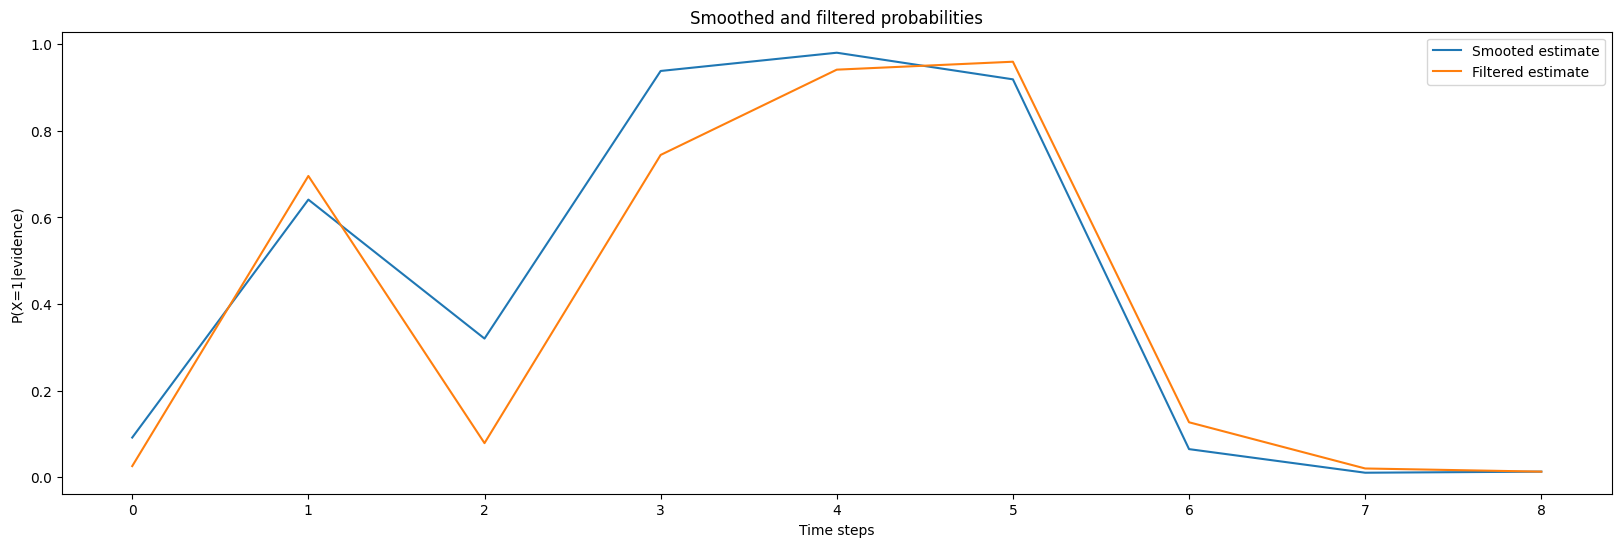

In [3]:
# Transition matrix with transModel(i, j)=P(X_t=j | X_{t-1}=i.I.e., the transition probabilities are given row-wise.
trans_model = np.array([[0.9, 0.1], [0.4, 0.6]])

# Column vector with prior probabilities for X_0
prior_model = np.array([0.8, 0.2])

# Sensor matrix (noHiddenStates x noSensorStates) with the sensor probabilities; the sensor probabilities are
# listed row-wise.
sensor_model = np.array([[0.95, 0.05], [0.1, 0.9]])

hmm = HMM(prior_model, trans_model, sensor_model)

# The state number of the observations being made
data = [0, 1, 0, 1, 1, 1, 0, 0, 0]

# Perform the forward backward propagations
hmm.forward_backward(data)

# Visualize the results
hmm.visualize(1)

# Part 3

## Exercise
The focus of this exercise is learning from incomplete observations and, in particular, learning the parameters of an HMM based on observed
sample sequences. 

Consider the umbrella model from AIMA and suppose that you are given the two observation sequences:
\begin{split}
  & 1: \langle U_1=y, U_2=n, U_3=y \rangle \\
  & 2: \langle U_1=y, U_2=n, U_3=n \rangle
\end{split}
For this exercise you should run two iterations of the EM algorithm (use the probabilities supplied in
the slides as initialization). 
* Trace the steps that you will have to go through.
* What are the resulting probabilities?

# Part 4

## Exercise 

Consider again the rain-umbrella model, and assume that for the specification of the transition probabilities
you had originally consulted a meteorologist who told you that the weather will stay the
same from one day to the next with probability $0.7$. Suppose now that another meteorologist tells you that the
first  meteorologist you consulted was being too pessimistic and that the probability should instead be $0.6$ if it is
raining and $0.8$ if it is not-raining, i.e., if it rains, then it will also rain tomorrow with probability $0.6$.

Assume now that you make the following observations over a 10 day period:
$$
\text{obs}= \langle umb,umb,umb,umb,\text{no-umb},\text{no-umb},\text{no-umb},umb,\text{no-umb},\text{no-umb}\rangle
$$  

For this exercise you should 
* explain how you will decide on which meteorologist you believe the most in based on your observations.
* perform your analysis (by hand) using the shorter sequence: $\langle umb,umb,umb\rangle$.
* (optional) perform the analysis based on the implementation above 

# Self study

Pyro also have support specifying hidden Markov models. The example below illustrates a Pyro implementation of the casino example above.
* Familiarize yourself with the code below and compare the results with the HMM implementation above.
* Assume now that the transition probabilities are unknow. Extend the model specification so that the transition probabilities are random variables for which we can calculate a posterior distribution. Hint: a natural choice would be the Dirichlet distribution, which generalizes the beta distribution (see Lecture 4).  
* Estimate the model parameters using the data in the file casinodata.csv

In [4]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.optim import Adam
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete, TraceTMC_ELBO
from pyro.infer.autoguide import AutoNormal, AutoDelta
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
torch.set_printoptions(precision=5)

/home/ebog/enviorments/PyTorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def casino_model(data):
    # Transition matrix with transModel(i, j)=P(X_t=j | X_{t-1}=i.I.e., the transition probabilities are given row-wise.
    # trans_model = torch.tensor(([[0.95, 0.05], [0.1, 0.9]]))
    prior_model = torch.tensor([0.5,0.5], dtype=float)
    trans_model = torch.tensor([[0.95, 0.05], [0.1, 0.9]], dtype=float)
    sensor_model = torch.tensor([[1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6], [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 5 / 10]], dtype=float)

    state = torch.tensor(0)
    for t, v in pyro.markov(enumerate(data)):
        if t == 0:
            state = pyro.sample(f"state_{t}", dist.Categorical(probs=prior_model),
                                infer={"enumerate": "parallel"})
        else:
            state = pyro.sample(f"state_{t}", dist.Categorical(probs=trans_model[state.type(torch.long), :]),
                                infer={"enumerate": "parallel"})
        pyro.sample(f"emission_{t}", dist.Categorical(probs=sensor_model[state.type(torch.long)]), obs=v)

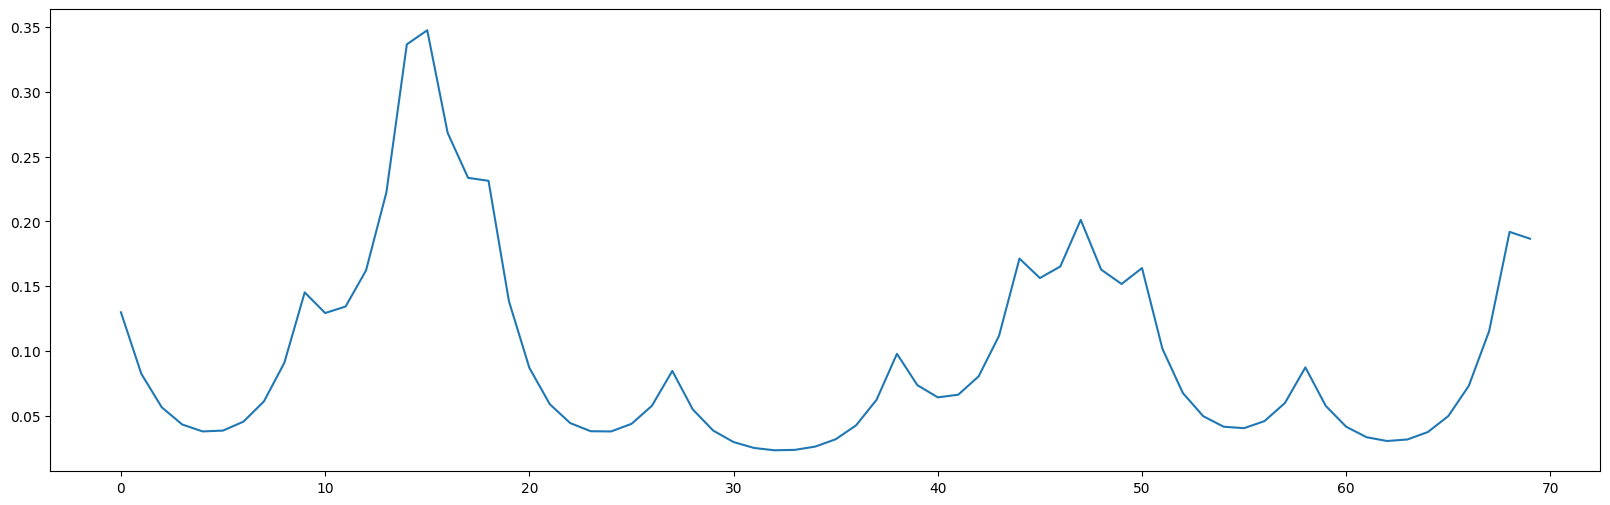

In [6]:
# Run options
LEARNING_RATE = 0.01

# Number of learning epochs
NUM_EPOCHS = 100

# clear param store
pyro.clear_param_store()

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# Observations
obs_str = '1355534526553366316351551526232112113462221263264265422344645323242361'
obs = []
for i in range(len(obs_str)):
    obs.append(int(obs_str[i]))
obs = torch.tensor(np.array(obs) - 1)
# Uncomment line below to retrieve 1000 samples
# obs = torch.tensor(np.genfromtxt('casinodata.csv', delimiter=','), dtype=float)

state_names = ['state_'+str(i) for i in range(len(obs))]
guide = AutoDelta(poutine.block(casino_model, hide=state_names))
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=0)
margin = elbo.compute_marginals(casino_model, guide, obs)

probs = []
torch.set_printoptions(precision=5)
for key, val in margin.items():
    #print(f'{key}: {val.probs}')
    probs.append(val.probs[1])
plt.plot(probs)

Use this code snippet for calculating the posterior over the model prameters (as per the exercise) 

In [7]:
svi = SVI(casino_model, guide, optimizer, loss=elbo)
losses = []
pbar = tqdm(range(NUM_EPOCHS))
for epoch in pbar:
    epoch_loss = svi.step(obs)
    losses.append(epoch_loss)
    pbar.set_description('{:.2f}'.format(np.mean(losses[-50:])))

plt.plot(losses)
plt.show()
print(pyro.get_param_store().get_param('AutoDelta.trans_model'))

NameError: name 'tqdm' is not defined